In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

from denovo_utils.parsers.io.fasta import FastaHandler
from denovo_utils.parsers.constants import EXTENSIONS
from denovo_utils.analysis.metaproteomics import count_analysis

from Bio import SeqIO


root_results = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
engine = "sage"
filename = "S03"

root_results_filtered = os.path.join(root_results, "psmlists/df")

2024-08-02 16:14:40.292251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:14:40.292287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:14:40.292298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# FASTA experiments

The FASTA defines what you expect to see in a sample when doing a search. Therefore, the only thing you will identify, is what you expect to see in your sample, which you define with your FASTA database. However, in de novo sequencing, you are not dependent on this required database. So the idea is to enrich the database with what you find in a de novo search and to find species-specific peptide sequences.

To evaluate the efficacy of de novo sequencing to capture unexpected species in a sample, a FASTA-blinding study will be performed. In essence, the database search is performed a number of times but with different databases, e.g. removing all sequences from a given species. Afterwards, the identifications that are lost in this search (those from the species present in the sample whereof the sequences are removed from the database) are tried to be recaptured by appending the de novo identifications and performing the search again. As final evaluation, the overlap will be calculated between the identifications of that species from the blinded fasta search, the original search, and the de novo enriched search.


Of course, some identifications will differ by adding de novo sequences. These could indicate a better peptide sequence proposition from de novo engines, albeit without support (and thus confidence) from a database. To evaluate this tendency, the same scoring evaluation will be performed (as done in notebook 6) but with a more interpretable scoring function -> hyperscore + MS2Rescore -> Percolator

# 0. Parse a fasta file

In [2]:
root_fasta = "/home/samva/Doctorate/data_directory/fasta"
pd.read_csv(os.path.join(root_fasta, "sdrf.tsv"))

,TAXONOMY,PROTEOME_ID,FILE,CONTENTS,DATE_DOWNLOAD
0,Homo sapiens (Human),UP000005640,uniprotkb_proteome_UP000005640_2024_07_31.fasta,sp;tr;isoforms;contaminant,31_07_2024
1,Homo sapiens (Human),UP000005640,uniprotkb_proteome_UP000005640_AND_revi_2024_0...,sp;isoforms;contaminant,31_07_2024
2,Homo sapiens (Human),UP000005640,UP000005640_9606.fasta,sp;contaminant,31_07_2024
3,Saccharomyces cerevisiae (strain ATCC 204508 /...,UP000002311,UP000002311.fasta,sp;contaminant,31_07_2024
4,Escherichia coli (strain K12),UP000000625,UP000000625.fasta,sp;contaminant,31_07_2024
5,Human;Yeast;E.coli,UP000000625;UP000002311;UP000005640,UP000005640_9606.fasta,sp;contaminant,31_07_2024
6,?,?,GUT_DB2MG.fasta,source:PXD023217,NaN
7,?,?,SIHUMI_DB1UNIPROT.fasta,source:PXD023217,NaN


In [3]:
fasta = FastaHandler()
fasta.read(
    os.path.join(
        root_fasta,
        "SIHUMI_DB1UNIPROT.fasta"
    )
)
fasta.dataframe["organism"] = fasta.dataframe["organism"].fillna("Contaminant")
fasta_organism_protein_dict = fasta.to_dict(key="organism", value="protein_id_full")

fasta.dataframe.head(2)

,name,protein_id,protein_id_full,protein_description,organism,gene_name,protein_existence,sequence_version,sequence
0,TrEMBL,B0MEB3,tr|B0MEB3|B0MEB3_9FIRM,Ribonuclease HII,Anaerostipes caccae DSM 14662,rnhB,3,1,"(M, R, E, E, S, Y, R, E, A, L, M, T, K, Q, E, ..."
1,TrEMBL,B0MBJ7,tr|B0MBJ7|B0MBJ7_9FIRM,Tagatose-6-phosphate kinase,Anaerostipes caccae DSM 14662,pfkB,3,1,"(M, I, T, T, V, T, L, N, A, S, I, D, K, A, Y, ..."


In [4]:
fasta.dataframe.organism.value_counts()

Bacteroides thetaiotaomicron (strain ATCC 29148 / DSM 2079 / NCTC 10582 / E50 / VPI-5482)    4782
Blautia sp. YL58                                                                             4502
Escherichia coli (strain K12)                                                                4306
Clostridium butyricum E4 str. BoNT E BL5262                                                  4245
Anaerostipes caccae DSM 14662                                                                3743
Erysipelatoclostridium ramosum DSM 1402                                                      3166
Lactobacillus plantarum (strain ATCC BAA-793 / NCIMB 8826 / WCFS1)                           3088
Bifidobacterium longum (strain NCC 2705)                                                     1725
Contaminant                                                                                   116
Name: organism, dtype: int64

## 0.2. Split up the fasta file by removing one species from it

In [5]:
row = fasta.dataframe.loc[0]
fasta.dataframe.head(2)

,name,protein_id,protein_id_full,protein_description,organism,gene_name,protein_existence,sequence_version,sequence
0,TrEMBL,B0MEB3,tr|B0MEB3|B0MEB3_9FIRM,Ribonuclease HII,Anaerostipes caccae DSM 14662,rnhB,3,1,"(M, R, E, E, S, Y, R, E, A, L, M, T, K, Q, E, ..."
1,TrEMBL,B0MBJ7,tr|B0MBJ7|B0MBJ7_9FIRM,Tagatose-6-phosphate kinase,Anaerostipes caccae DSM 14662,pfkB,3,1,"(M, I, T, T, V, T, L, N, A, S, I, D, K, A, Y, ..."


In [6]:
from Bio.SeqIO import SeqRecord

In [23]:
seq_record = SeqIO.parse(os.path.join(
        root_fasta,
        "SIHUMI_DB1UNIPROT.fasta"
    ), format="fasta")
for entry in seq_record:
    entry_parsed = fasta._parse_fasta_header(entry.description)
    break

entry_parsed = {k:[v] for k, v in entry_parsed.items()}
entry_parsed["sequence"] = [entry.seq]
row = pd.DataFrame(entry_parsed).loc[0]

In [30]:
prefix_mapping = {
    "protein_id_full": "",
    "protein_description": "",
    "organism": "OS=",
    "gene_name": "GN=",
    "protein_existence": "PE=",
    "sequence_version": "SV="
}

def row_to_seqrecord(row):
    sequence = row["sequence"]
    id_ = row["protein_id_full"]
    name= row["protein_id_full"]
    description_list = []
    for col in [
        "protein_id_full",
        "protein_description",
        "organism",
        "gene_name",
        "protein_existence",
        "sequence_version"
    ]:
        value = row[col]
        if value:
            description_list.append(prefix_mapping[col]+row[col])
    description = " ".join(description_list)
    return SeqRecord(
        seq=sequence,
        id=id_,
        name=name,
        description=description
    )

seqrecord_series = fasta.dataframe.apply(row_to_seqrecord, axis=1)

In [31]:
seqrecord_series.shape

(29673,)

In [32]:
seqrecord_series[fasta.dataframe["species"]==["Contaminant"]]

KeyError: 'species'

# 1. Check how many species-specific peptides were detected in S-samples with database searching

100%|██████████| 82759/82759 [00:00<00:00, 2505568.18it/s]


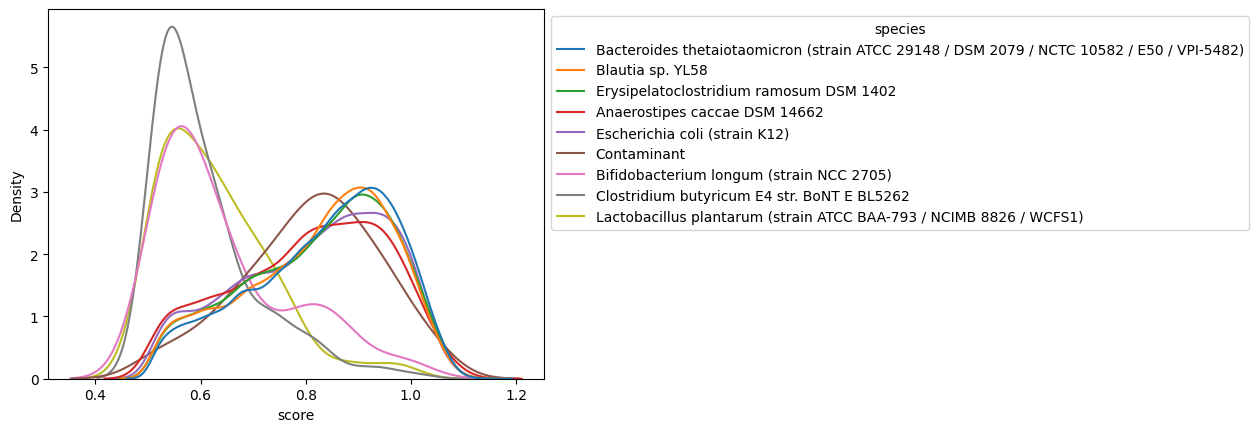

In [13]:
filename = "S03"

df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted"],
    fasta_dict=fasta_organism_protein_dict,
    plot=True
)

In [14]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,44577,45270
1,Blautia sp. YL58,14386,16565
2,Erysipelatoclostridium ramosum DSM 1402,12880,13896
3,Escherichia coli (strain K12),5324,5742
4,Anaerostipes caccae DSM 14662,2304,3982
5,Clostridium butyricum E4 str. BoNT E BL5262,181,983
6,Bifidobacterium longum (strain NCC 2705),105,310
7,Contaminant,92,94
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,87,368


## Try for another S-file

100%|██████████| 115334/115334 [00:00<00:00, 2426761.87it/s]


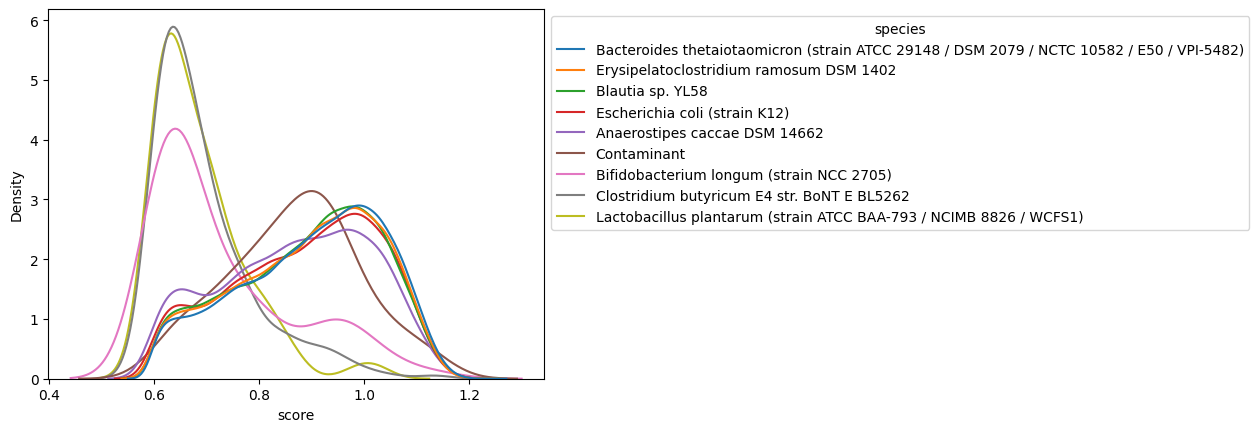

In [15]:
filename = "S05"

df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted"],
    fasta_dict=fasta_organism_protein_dict,
    plot=True
)

In [16]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,61438,62402
1,Blautia sp. YL58,20051,23233
2,Erysipelatoclostridium ramosum DSM 1402,18220,19725
3,Escherichia coli (strain K12),7519,8108
4,Anaerostipes caccae DSM 14662,3398,5826
5,Clostridium butyricum E4 str. BoNT E BL5262,243,1399
6,Contaminant,137,141
7,Bifidobacterium longum (strain NCC 2705),123,442
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,120,554


Metaproteomics rabbit hole:

Are the species-specific peptides that were found here, which follow a distinct distribution and have only a very limited of supporting peptides, actually very similar to what are supposed to be 'entrapment' sequences which actually follow the decoy distribution better?

Instead of only looking at the accepted PSMs, look at all of the target PSM's without filtering. If they indeed follow the decoy distribution, this could support the hypothesis

In [17]:
df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted", "target_rejected"],
    fasta_dict=fasta_organism_protein_dict,
    plot=False
)

100%|██████████| 156093/156093 [00:00<00:00, 2552641.51it/s]


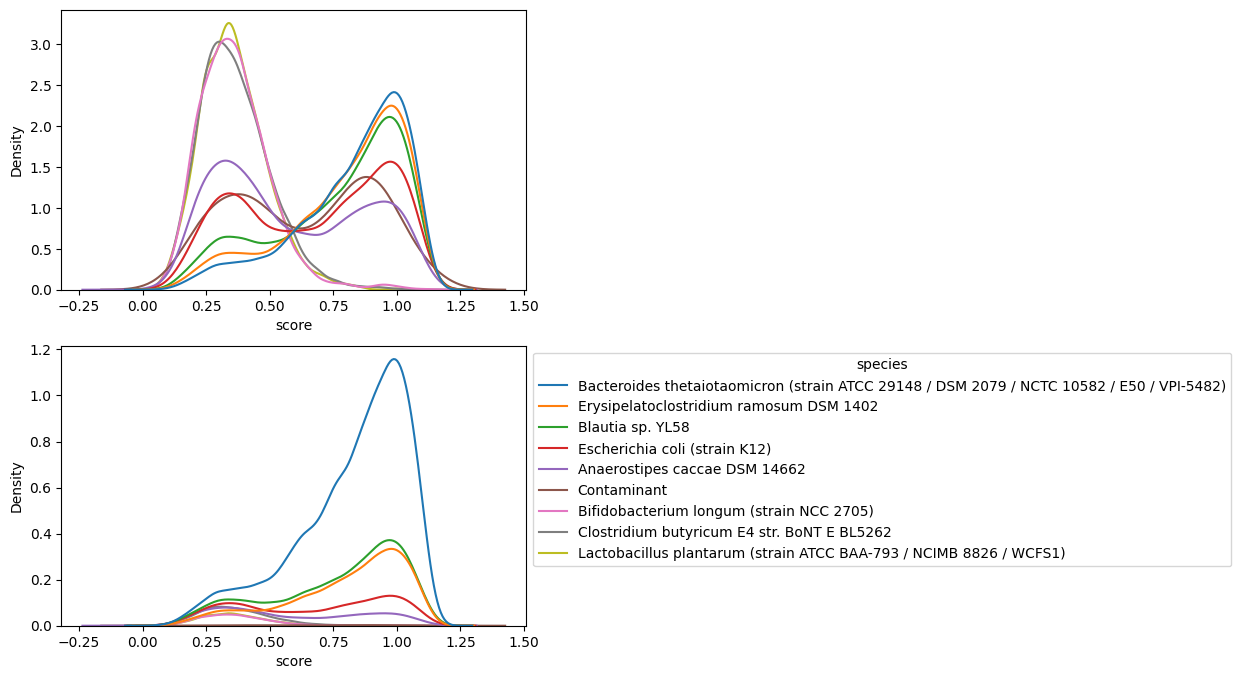

In [18]:
df_sage_unique_species = df_sage_filtered[df_sage_filtered["species_n"]==1].copy()
df_sage_unique_species["species"] = df_sage_unique_species["species"].apply(lambda x: x[0])

fig, ax = plt.subplots(2,1, figsize=(6,8))
sns_plot = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=False,
    ax=ax[0],
    legend=False
)
sns_plot2 = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=True,
    ax=ax[1]
)
sns.move_legend(sns_plot2, "upper left", bbox_to_anchor=(1, 1))

In [19]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,72746,73810
1,Blautia sp. YL58,26697,30268
2,Erysipelatoclostridium ramosum DSM 1402,22506,24195
3,Escherichia coli (strain K12),12621,13309
4,Anaerostipes caccae DSM 14662,7590,10365
5,Clostridium butyricum E4 str. BoNT E BL5262,4139,5447
6,Lactobacillus plantarum (strain ATCC BAA-793 /...,2507,3002
7,Bifidobacterium longum (strain NCC 2705),2403,2758
8,Contaminant,256,262


The following species are probably not in the sample:
- Bifidobacterium longum
- Clostridium butyricum
- Lactobacillus plantarum

Don't know about, maybe just present at lower abundance:
- Anaerostipes caccae
- Eschericihia coli

These follow a similar distribution as the contaminants, which are probably in the sample!

In short, there seem to be 3 distributions

If we follow this train of thought, these species could in fact function as negative controls for the de novo pipeline when performing the fasta-blinding experiment.

Potential artefact however is that there are much less sequences of these species in the fasta file. I should actually count the number of unique peptides that can be found for these species.

# 2. Build the de novo fasta blinding pipeline